In [1]:
# Set thread count for network propagation functions
import mkl
mkl.set_num_threads(4)

# Import other required packages
import os
import pandas as pd

In [12]:
# Load functions for performing network GWAS from python module file
%run './network_GWAS_functions.py'
%run './network_GWAS_results_analysis_functions.py'

In [3]:
wd = '/cellar/users/jkhuang/Data/Projects/Network_GWAS/'

In [4]:
# Load network for propagation
network_file = '/cellar/users/jkhuang/Data/Projects/Network_Analysis/Data/Networks_for_Analysis/Composite_Networks/CompositeNetwork-2_Symbol.txt'
network = load_network(network_file, delimiter='\t', verbose=True)

Network File Loaded: 18.7843329906 seconds
Number of network nodes: 19781
Number of network edges: 2724724


In [6]:
# Load gene association p-values calculated from GWAS
GWAS_pvals_file = wd+'Data/IGAP/IGAP_boosting_results/vegas_results/vegas_pvals.txt'
GWAS_pvals = pd.read_csv(GWAS_pvals_file, sep='\t', index_col=0, header=-1)[1]
print 'Gene P-values from GWAS loaded:', GWAS_pvals.shape[0], 'gene associations'

Gene P-values from GWAS loaded: 23166 gene associations


In [9]:
# Propagate gene with GWAS p-values less than specified threshold
GWAS_pval_seed_thresh = 1e-6
propagation_results_table = random_walk(network, GWAS_pvals, p_thresh=GWAS_pval_seed_thresh, save_path=None)

Significant genes to be propagated: Index([u'TRAPPC6A', u'APOE', u'MS4A6E', u'BCL3', u'CR1', u'CBLC', u'CLASRP',
       u'EPHA1', u'SORL1', u'ZNF296', u'CLPTM1', u'BIN1', u'RELB', u'FBXO46',
       u'CEACAM16', u'GEMIN7', u'PVR', u'PPP1R37', u'MS4A2', u'PICALM',
       u'APOC4', u'APOC2', u'APOC1', u'PVRL2', u'IGSF23', u'NKPD1', u'CLU',
       u'EXOC3L2', u'MS4A6A', u'BCAM', u'BLOC1S3', u'MS4A4A', u'ABCA7',
       u'TOMM40', u'HBEGF', u'CD2AP'],
      dtype='object', name=0)
Calculated Alpha: 0.56
Adjacency matrix normalized (asymmetric - default)
36 / 36 found in network
Missing network seeds: []
Network propagation complete: 25 iterations


<string>:123: RuntimeWarning: divide by zero encountered in log10


Combined network propagation results constructed


In [14]:
# Load gold standard gene sets
gold_standards_file = wd+'/Data/IGAP/Alzheimers_Gold_Standard_sets.txt'
gs_sets = load_GS_sets(gold_standards_file, delimiter='\t', verbose=True)

2 gold standard gene sets loaded from: /cellar/users/jkhuang/Data/Projects/Network_GWAS//Data/IGAP/Alzheimers_Gold_Standard_sets.txt


In [16]:
outdir=wd+'Data/IGAP/IGAP_boosting_results/IGAP_prop/'

In [19]:
# Perform Precision, Recall and AUPRC calculations for each gold standard gene set
NBGWAS_AUPRCs = {}
for gs_set in gs_sets:
	recovery_plot_title = gs_set+' Recovery Performance'
	GWAS_AUPRC, prop_AUPRC, adjp_AUPRC = PRC_plots(propagation_results_table, gs_sets[gs_set], 
                                                   p_thresh=GWAS_pval_seed_thresh, outdir=outdir, 
                                                   plot_title=recovery_plot_title, 
                                                   file_prefix='_'.join(gs_set.split(' ')))

	recovery_condition1 = gs_set+' GWAS P-Value Only Recovery AUPRC'
	NBGWAS_AUPRCs[recovery_condition1] = GWAS_AUPRC
	recovery_condition2 = gs_set+' Propagation Only Recovery AUPRC'
	NBGWAS_AUPRCs[recovery_condition2] = prop_AUPRC
	recovery_condition3 = gs_set+' GWAS x Prop Recovery AUPRC'
	NBGWAS_AUPRCs[recovery_condition3] = adjp_AUPRC	
NBGWAS_AUPRCs = pd.Series(NBGWAS_AUPRCs, name='GS Recovery AUPRCs')    
NBGWAS_AUPRCs.to_csv(outdir+'GS_recovery_AUPRCs.txt', sep='\t')

In [21]:
# Plot network propagation distributions
score_dist_plot_title = 'Propagation Distributions'
prop_score_distributions(propagation_results_table, gs_sets, p_thresh=GWAS_pval_seed_thresh, 
                         weak_p_thresh=1e-4, outdir=outdir, plot_title=score_dist_plot_title)

### Load other network-based GWAS method results

In [34]:
network_nodes = network.nodes()
network_GWAS_pvals = GWAS_pvals.ix[network_nodes].fillna(1)
seed_genes = network_GWAS_pvals[network_GWAS_pvals <= GWAS_pval_seed_thresh].index
non_seed_genes = network_GWAS_pvals[network_GWAS_pvals > GWAS_pval_seed_thresh].index
network_non_seed_dis_gs = set(network_nodes).intersection(gs_sets['DisGeNET Gold Standard']-set(seed_genes))
network_non_seed_exp_gs = set(network_nodes).intersection(gs_sets['Expression Gold Standard']-set(seed_genes))

In [35]:
GWAB_results = pd.read_csv('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/IGAP/IGAP_boosting_results/IGAP_gwab/IGAP_gwab_10KB.output.txt', sep='\t')
GWAB_DisGeNET_pre, GWAB_DisGeNET_rec, GWAB_DisGeNET_AUPRC = PRC(GWAB_results.set_index('Gene_Symbol')['GWAB_Score'].ix[non_seed_genes],
                                                                network_non_seed_dis_gs, False)

GWAB_Expression_pre, GWAB_Expression_rec, GWAB_Expression_AUPRC = PRC(GWAB_results.set_index('Gene_Symbol')['GWAB_Score'].ix[non_seed_genes],
                                                                      network_non_seed_exp_gs, False)


In [38]:
netWAS_results = pd.read_csv('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/IGAP/IGAP_boosting_results/netwas_results/IGAP_AD.txt', header=-1, comment='#', sep='\t')
netWAS_results.columns = ['Gene_Symbol' , 'Training_Label', 'NetWAS_Score']
NetWAS_DisGeNET_pre, NetWAS_DisGeNET_rec, NetWAS_DisGeNET_AUPRC = PRC(netWAS_results.set_index('Gene_Symbol')['NetWAS_Score'].ix[non_seed_genes],
                                                                      network_non_seed_dis_gs, False)

NetWAS_Expression_pre, NetWAS_Expression_rec, NetWAS_Expression_AUPRC = PRC(netWAS_results.set_index('Gene_Symbol')['NetWAS_Score'].ix[non_seed_genes],
                                                                            network_non_seed_exp_gs, False)


### Compare results to null network performance (and other network-based GWAS methods)

In [76]:
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [39]:
null_results_dir = wd+'Data/IGAP/IGAP_boosting_results/IGAP_prop/null_net_results/'
job_name = 'Null_Alz_NBGWAS'

In [42]:
# Get null AUPRC distributions
DisGeNET_prop_only_null_AUPRCs = []
DisGeNET_gwasXprop_null_AUPRCs = []
Expression_prop_only_null_AUPRCs = []
Expression_gwasXprop_null_AUPRCs = []
for i in range(1,51):
    AUPRC_table_fn = null_results_dir+job_name+'_'+repr(i)+'/'+'GS_recovery_AUPRCs.txt'
    AUPRC_table = pd.read_csv(AUPRC_table_fn, sep='\t', index_col=0, header=-1)[1]
    DisGeNET_prop_only_null_AUPRCs.append(AUPRC_table.ix['DisGeNET Gold Standard Propagation Only Recovery AUPRC'])
    DisGeNET_gwasXprop_null_AUPRCs.append(AUPRC_table.ix['DisGeNET Gold Standard GWAS x Prop Recovery AUPRC'])
    Expression_prop_only_null_AUPRCs.append(AUPRC_table.ix['Expression Gold Standard Propagation Only Recovery AUPRC'])
    Expression_gwasXprop_null_AUPRCs.append(AUPRC_table.ix['Expression Gold Standard GWAS x Prop Recovery AUPRC'])   

In [63]:
z1 = (NBGWAS_AUPRCs['DisGeNET Gold Standard Propagation Only Recovery AUPRC'] - np.mean(DisGeNET_prop_only_null_AUPRCs)) / np.std(DisGeNET_prop_only_null_AUPRCs)
p1 = 1-stats.norm.cdf(z1)

z2 = (NBGWAS_AUPRCs['DisGeNET Gold Standard GWAS x Prop Recovery AUPRC'] - np.mean(DisGeNET_gwasXprop_null_AUPRCs)) / np.std(DisGeNET_gwasXprop_null_AUPRCs)
p2 = 1-stats.norm.cdf(z2)

z3 = (NBGWAS_AUPRCs['Expression Gold Standard Propagation Only Recovery AUPRC'] - np.mean(Expression_prop_only_null_AUPRCs)) / np.std(Expression_prop_only_null_AUPRCs)
p3 = 1-stats.norm.cdf(z3)

z4 = (NBGWAS_AUPRCs['Expression Gold Standard GWAS x Prop Recovery AUPRC'] - np.mean(Expression_gwasXprop_null_AUPRCs)) / np.std(Expression_gwasXprop_null_AUPRCs)
p4 = 1-stats.norm.cdf(z4)

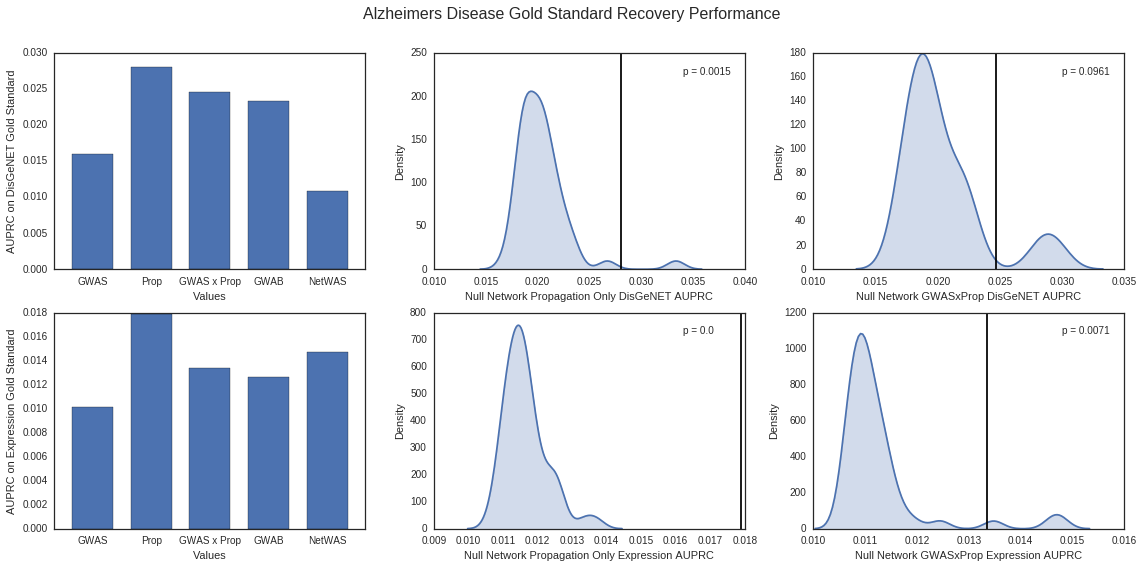

In [79]:
# Plot recovery results
plt.subplots(2,3,figsize=(16,8))

ax1 = plt.subplot(2,3,1)
index, bar_width = np.arange(5), 0.7
ax1.bar(index, [NBGWAS_AUPRCs['DisGeNET Gold Standard GWAS P-Value Only Recovery AUPRC'], 
                NBGWAS_AUPRCs['DisGeNET Gold Standard Propagation Only Recovery AUPRC'], 
                NBGWAS_AUPRCs['DisGeNET Gold Standard GWAS x Prop Recovery AUPRC'], 
                GWAB_DisGeNET_AUPRC, NetWAS_DisGeNET_AUPRC], bar_width)
ax1.set_xlim((bar_width-1,5))
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(('GWAS', 'Prop', 'GWAS x Prop', 'GWAB', 'NetWAS'))
ax1.set_xlabel('Values')
ax1.set_ylabel('AUPRC on DisGeNET Gold Standard')

ax2 = plt.subplot(2,3,2)
sns.kdeplot(np.array(DisGeNET_prop_only_null_AUPRCs), ax=ax2, shade=True)
ax2.set_xlabel('Null Network Propagation Only DisGeNET AUPRC')
ax2.set_ylabel('Density')
ax2.axvline(NBGWAS_AUPRCs['DisGeNET Gold Standard Propagation Only Recovery AUPRC'], color='black')
ax2.annotate('p = '+repr(round(p1, 4)), xy=(0.8, 0.9), xycoords="axes fraction")

ax3 = plt.subplot(2,3,3)
sns.kdeplot(np.array(DisGeNET_gwasXprop_null_AUPRCs), ax=ax3, shade=True)
ax3.set_xlabel('Null Network GWASxProp DisGeNET AUPRC')
ax3.set_ylabel('Density')
ax3.axvline(NBGWAS_AUPRCs['DisGeNET Gold Standard GWAS x Prop Recovery AUPRC'], color='black')
ax3.annotate('p = '+repr(round(p2, 4)), xy=(0.8, 0.9), xycoords="axes fraction")

ax4 = plt.subplot(2,3,4)
index, bar_width = np.arange(5), 0.7
ax4.bar(index, [NBGWAS_AUPRCs['Expression Gold Standard GWAS P-Value Only Recovery AUPRC'], 
                NBGWAS_AUPRCs['Expression Gold Standard Propagation Only Recovery AUPRC'], 
                NBGWAS_AUPRCs['Expression Gold Standard GWAS x Prop Recovery AUPRC'], 
                GWAB_Expression_AUPRC, NetWAS_Expression_AUPRC], bar_width)
ax4.set_xlim((bar_width-1,5))
ax4.set_xticks(index + bar_width / 2)
ax4.set_xticklabels(('GWAS', 'Prop', 'GWAS x Prop', 'GWAB', 'NetWAS'))
ax4.set_xlabel('Values')
ax4.set_ylabel('AUPRC on Expression Gold Standard')

ax5 = plt.subplot(2,3,5)
sns.kdeplot(np.array(Expression_prop_only_null_AUPRCs), ax=ax5, shade=True)
ax5.set_xlabel('Null Network Propagation Only Expression AUPRC')
ax5.set_ylabel('Density')
ax5.axvline(NBGWAS_AUPRCs['Expression Gold Standard Propagation Only Recovery AUPRC'], color='black')
ax5.annotate('p = '+repr(round(p3, 4)), xy=(0.8, 0.9), xycoords="axes fraction")

ax6 = plt.subplot(2,3,6)
sns.kdeplot(np.array(Expression_gwasXprop_null_AUPRCs), ax=ax6, shade=True)
ax6.set_xlabel('Null Network GWASxProp Expression AUPRC')
ax6.set_ylabel('Density')
ax6.axvline(NBGWAS_AUPRCs['Expression Gold Standard GWAS x Prop Recovery AUPRC'], color='black')
ax6.annotate('p = '+repr(round(p4, 4)), xy=(0.8, 0.9), xycoords="axes fraction")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Alzheimer''s Disease Gold Standard Recovery Performance', fontsize=16)
plt.savefig(outdir+'Gold_Standard_Recovery_Performance_Plots.pdf')